In [1]:
import environ

env = environ.Env()
environ.Env.read_env()
#Todo only load the repo folder
DataSetsPath     = env('DataSetsPath')     #* get the path of the script
ModelsPath       = env('ModelsPath')       #* get the path of the script
FitFunctionsPath = env('FitFunctionsPath') #* get the path of the script
root_Data        = env('DataSet_Dogs_Vs_catsPath')         #* get the path of the dataSet of the fist 12_000 img of https://www.kaggle.com/c/dogs-vs-cats
root_Data_Val    = env('DataSet_Dogs_Vs_catsValPath')      #* get the path of the dataSet of the last 500 img of https://www.kaggle.com/c/dogs-vs-cats
model_save_dir   = env('model_save_dir')   #* get the path where we will save the model


import sys
sys.path.append(DataSetsPath)
sys.path.append(ModelsPath)
sys.path.append(FitFunctionsPath)


import torch
import torchvision.transforms as transforms
from DataSets.dataSet_CatsVsDogs import DataSet_Img_To_Label
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
print("device = ", device)  

device =  cuda


In [2]:
image_Height   = 300
image_Width    = 300
image_Channels = 3
batch_size     = 64


In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, RandomSampler


data_augmentation = transforms.Compose([
                        #* Compose = compoues a list of function
                        transforms.ToPILImage(),
                        transforms.Resize((image_Height, image_Width)),
                        # transforms.RandomRotation(degrees = 5),  # Randomly rotate the image by up to 5 degrees
                                        
                        #* ToPILImage = cahnge the data type from PyTorch tensor or a NumPy ndarray to : A PIL (Python Imaging Library)
                        # transforms.RandomVerticalFlip(),
                        # transforms.RandomHorizontalFlip(),
                        # transforms.RandomRotation(degrees=15),  
                        transforms.ToTensor(), 
                        #* change the data type from Numpy or PIL to tensor
                        ])


myDataSet     = DataSet_Img_To_Label(root_Data,     data_augmentation, test = True, dataSize = 3000)
myDataSetVal  = DataSet_Img_To_Label(root_Data_Val, data_augmentation, test = True, dataSize = 300) 
print("len(myDataSet) = ", len(myDataSet))
print("len(myDataSetVal) = ", len(myDataSetVal))

len(myDataSet) =  3000
len(myDataSetVal) =  300


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from Models.models_CatsVsDogs import modelCNN
from Models.models_CatsVsDogs import modelSiLU

myModel = modelSiLU(HEIGHT = image_Height, WIDTH = image_Width, CHANNELS = image_Channels)

In [18]:
import importlib
import FitFunctions.fitFunctionsForCatsVsDogs

importlib.reload(FitFunctions.fitFunctionsForCatsVsDogs)
from FitFunctions.fitFunctionsForCatsVsDogs import trainerCatsVsDogs

myTrainer = trainerCatsVsDogs(model = myModel,
                            dataSet = myDataSet,
                            device = device,
                            batch_size = 128,
                            # dataSet_Val = myDataSetVal,
                            model_save_dir = model_save_dir
                            )


In [19]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from FitFunctions.fitFunctionsForCatsVsDogs import train_modelCNN

# criterion = nn.BCELoss()
# criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()
opt_model = optim.Adam(myModel.parameters(), lr = 0.001)
myTrainer.trainModel(opt_model=opt_model, criterion= criterion, num_epochs = 10)


Epoch 1/10 process: 95: 100%|██████████| 24/24 [00:07<00:00,  3.13it/s, modelLoss=0]       


Epoch completed, TRAIN MAE: 0.0000
Epoch completed, TRAIN ACC: 1.0000
entroe 1


Epoch 2/10 process: 4:   8%|▊         | 2/24 [00:00<00:07,  3.02it/s, modelLoss=0]

In [22]:
import os
files = os.listdir(model_save_dir)
file_paths = [os.path.join(model_save_dir, file) for file in files]
file_paths.sort(key=os.path.getmtime, reverse=True)

lastSavedModel = file_paths[0]
print(lastSavedModel)

C:/Users/malekir1/Documents/Repositories/DeepLearningToolkit/TestNotebooks/fitedModels\checkpoint_epoch_10_ACC_Val_0.861.pt


In [23]:

#* load the best model
myModel.load_state_dict(torch.load(lastSavedModel)['model_state_dict'])

<All keys matched successfully>

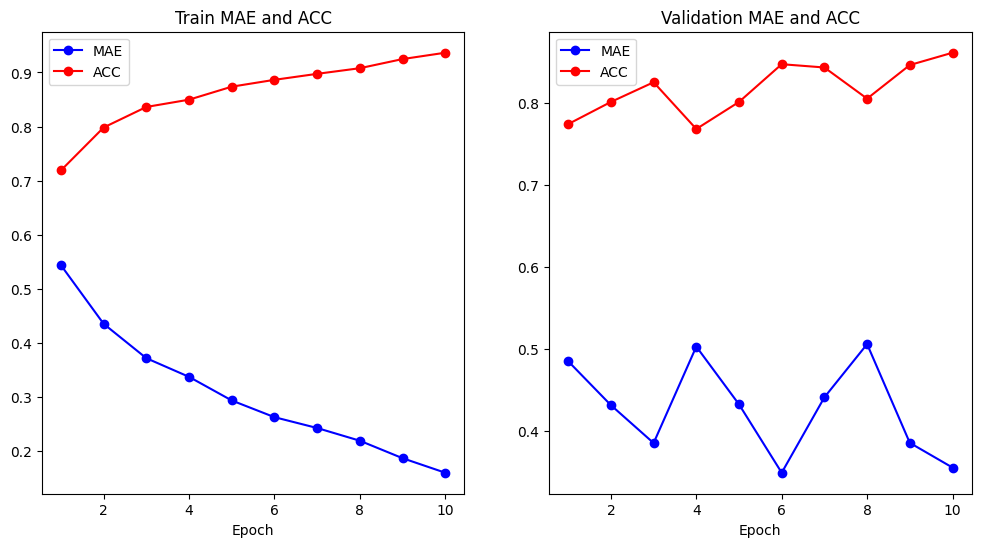

In [24]:
import matplotlib.pyplot as plt

Epochs_values     = range(1, len(myTrainer.history['train_MAE']) + 1)
Epochs_values_Val = range(1, len(myTrainer.history['train_MAE']) + 1)


# Create two subplots (one for MAE and one for MAE_Val) in a single row
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot MAE and ACC in train at the first subplot
plt1.plot(Epochs_values,     myTrainer.history['train_MAE'], marker='o', color='blue', label='MAE')
plt1.plot(Epochs_values_Val, myTrainer.history['train_ACC'], marker='o', color='red', label='ACC')
# plt1.set_ylabel('train MAE and ACC')
plt1.set_xlabel('Epoch')
plt1.set_title('Train MAE and ACC')

# Plot MAE and ACC in validation at the second subplot
plt2.plot(Epochs_values,     myTrainer.history['val_MAE'], marker='o', color='blue', label='MAE')
plt2.plot(Epochs_values_Val, myTrainer.history['val_ACC'], marker='o', color='red', label='ACC')
# plt2.set_ylabel('MAE and ACC')
plt2.set_xlabel('Epoch')
plt2.set_title('Validation MAE and ACC')


# Add legend to each subplot
plt1.legend()
plt2.legend()



# Show the plots
plt.show()


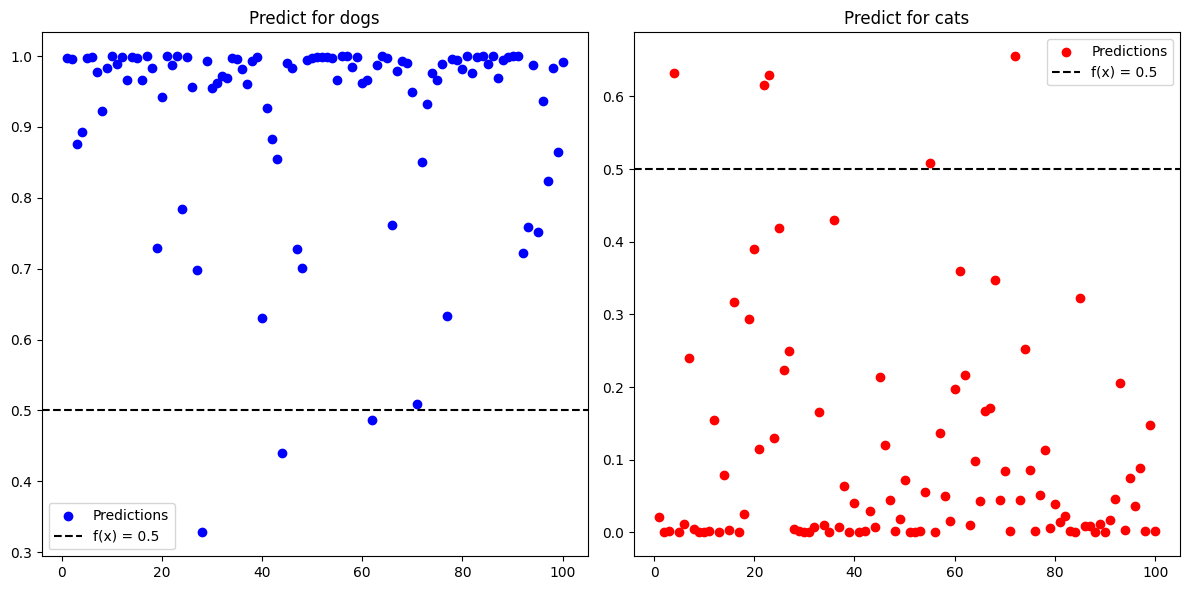

In [25]:
import numpy as np
import os
from PIL import Image

img_pth = root_Data + '/'

dog_paths = ['dog.' + str(i) + '.jpg' for i in range(0, 100)]
cat_paths = ['cat.' + str(i) + '.jpg' for i in range(0, 100)]

def getArrayBatch(paths):

    tensor_batch = []
    for path in paths:
        img  = os.path.join(img_pth + path)
        img  = np.array(Image.open(img))
        img  = img [:, :, :3]
        img = data_augmentation(img)
        tensor_batch.append(img)

    tensor_batch = torch.stack(tensor_batch).to(device)
    with torch.no_grad():
        myModel.eval()
        tensor_batch = myModel(tensor_batch)
    tensor_batch = torch.softmax(tensor_batch, dim=1)[:, 0].cpu().detach().numpy()  # Extract probability for the positive class
    # tensor_batch = tensor_batch.cpu().detach().numpy()
    return tensor_batch

predict_Array_dogs = getArrayBatch(dog_paths)
predict_Array_cats = getArrayBatch(cat_paths)

import matplotlib.pyplot as plt

num_images_dogs     = range(1, len(predict_Array_dogs) + 1)
num_images_cats = range(1, len(predict_Array_dogs) + 1)

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 6))

#* Plot points for dogs
plt1.scatter(num_images_dogs, predict_Array_dogs, marker='o', color='blue', label = 'Predictions')
plt1.set_title('Predict for dogs')

#* Plot points for cats
plt2.scatter(num_images_cats, predict_Array_cats, marker='o', color='red', label = 'Predictions')
plt2.set_title('Predict for cats')

#* Add horizontal line at y=0.5
plt1.axhline(y=0.5, color='black', linestyle='--', label='f(x) = 0.5')
plt2.axhline(y=0.5, color='black', linestyle='--', label='f(x) = 0.5')

#* Add legends
plt1.legend()
plt2.legend()

plt.tight_layout()
plt.show()



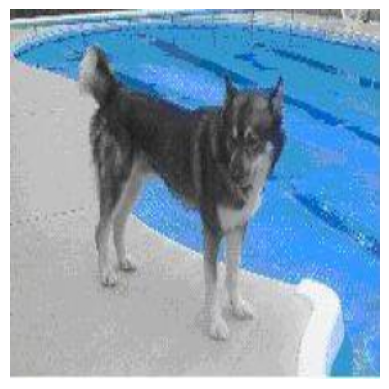

array([0.9744024], dtype=float32)

In [28]:
#TODO use the model 
import os 
from PIL import Image

img_pth = root_Data_Val + '/dog.12403.jpg' 

img  = os.path.join(img_pth)
img  = np.array(Image.open(img))
img  = img [:, :, :3]
img  = data_augmentation(img)


img_array = img.permute(1, 2, 0).numpy()  # Assuming the tensor is of shape [3, height, width]
# Plot the image
img = img.unsqueeze(0)
plt.imshow(img_array)
plt.axis('off')  # Turn off axis
plt.show()

torch.softmax(myModel(img.to(device)), dim=1)[:, 0].cpu().detach().numpy()
